In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Orden correcto de los días
dias_orden = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Carga de archivos
ventas = pd.read_csv("ventas.csv")  # columnas: num_tie, dia_semana, tipocompra, cartera, promedio_venta
abonos = pd.read_csv("abonos.csv")  # columnas: dia_semana, tienda, cartera, promedio_abonos
# Limpiar espacios en los nombres de días
ventas["dia_semana"] = ventas["dia_semana"].str.strip()
abonos["dia_semana"] = abonos["dia_semana"].str.strip()

In [3]:
# Entradas por VENTA DE CONTADO
ventas_contado = ventas[ventas["tipocompra"].str.lower() == "contado"]
contado_por_tienda = ventas_contado.groupby(["dia_semana", "num_tie"])["promedio_venta"].sum().reset_index()
contado_por_tienda.rename(columns={"promedio_venta": "entrada_contado", "num_tie": "tienda"}, inplace=True)

In [4]:
# Salidas por PRÉSTAMOS
prestamos = ventas[ventas["cartera"].str.lower() == "prestamos"]
salida_prestamos = prestamos.groupby(["dia_semana", "num_tie"])["promedio_venta"].sum().reset_index()
salida_prestamos.rename(columns={"promedio_venta": "salida_prestamos", "num_tie": "tienda"}, inplace=True)


In [5]:
# Entradas por ABONOS
abonos_por_tienda = abonos.groupby(["dia_semana", "tienda"])["promedio_abonos"].sum().reset_index()
abonos_por_tienda.rename(columns={"promedio_abonos": "entrada_abonos"}, inplace=True)

In [6]:
# Unimos todo por tienda y día
flujo_efectivo = contado_por_tienda.merge(abonos_por_tienda, on=["dia_semana", "tienda"], how="outer") \
                                   .merge(salida_prestamos, on=["dia_semana", "tienda"], how="outer")

In [7]:
# Rellenamos nulos con 0
flujo_efectivo.fillna(0, inplace=True)

In [8]:

# Flujo neto
flujo_efectivo["flujo_neto"] = (
    flujo_efectivo["entrada_contado"] +
    flujo_efectivo["entrada_abonos"] -
    flujo_efectivo["salida_prestamos"]
)

In [9]:
# Ordenar por tienda y día de la semana
flujo_efectivo["dia_semana"] = pd.Categorical(flujo_efectivo["dia_semana"], categories=dias_orden, ordered=True)
flujo_efectivo.sort_values(by=["tienda", "dia_semana"], inplace=True)
flujo_efectivo.head()

,dia_semana,tienda,entrada_contado,entrada_abonos,salida_prestamos,flujo_neto
21,Monday,82,160569.03,516719.75,157666.0,519622.78
105,Tuesday,82,138384.00,474031.50,180299.5,432116.00
126,Wednesday,82,132283.65,446885.60,214296.8,364872.45
84,Thursday,82,199857.77,463231.00,183849.2,479239.57
0,Friday,82,187675.42,490253.60,173654.2,504274.82


In [10]:
# Calcular ROP como promedio de salidas * 7 (reposiciones semanales)
rop_por_tienda = flujo_efectivo.groupby("tienda")["salida_prestamos"].mean().reset_index()
rop_por_tienda["ROP_efectivo"] = rop_por_tienda["salida_prestamos"] * 7  # cambiar a 3.5 si quieres media semana
rop_por_tienda.drop(columns=["salida_prestamos"], inplace=True)

# Unir y continuar igual
flujo_efectivo = flujo_efectivo.merge(rop_por_tienda, on="tienda", how="left")
flujo_efectivo["Max"] = 250000
flujo_efectivo["Min"] = flujo_efectivo["ROP_efectivo"] * 0.6
limite_2a3 = (flujo_efectivo["Max"] + flujo_efectivo["ROP_efectivo"]) / 2

condiciones = [
    flujo_efectivo["flujo_neto"] < flujo_efectivo["Min"],
    (flujo_efectivo["flujo_neto"] >= flujo_efectivo["Min"]) & (flujo_efectivo["flujo_neto"] < flujo_efectivo["ROP_efectivo"]),
    (flujo_efectivo["flujo_neto"] >= flujo_efectivo["ROP_efectivo"]) & (flujo_efectivo["flujo_neto"] < limite_2a3),
    (flujo_efectivo["flujo_neto"] >= limite_2a3) & (flujo_efectivo["flujo_neto"] <= flujo_efectivo["Max"]),
    flujo_efectivo["flujo_neto"] > flujo_efectivo["Max"]
]

zonas = [0, 1, 2, 3, 4]
flujo_efectivo["Zona"] = np.select(condiciones, zonas)
flujo_efectivo["Rango_Max_ROP"] = flujo_efectivo["Max"] - flujo_efectivo["ROP_efectivo"]

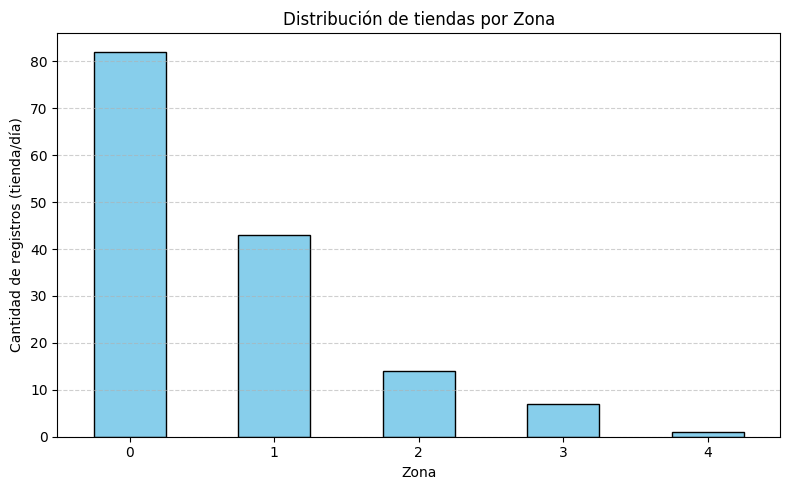

In [11]:
# Contar cuántos registros hay en cada zona
zona_counts = flujo_efectivo["Zona"].value_counts().sort_index()

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
zona_counts.plot(kind="bar", color='skyblue', edgecolor='black')
plt.title("Distribución de tiendas por Zona")
plt.xlabel("Zona")
plt.ylabel("Cantidad de registros (tienda/día)")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

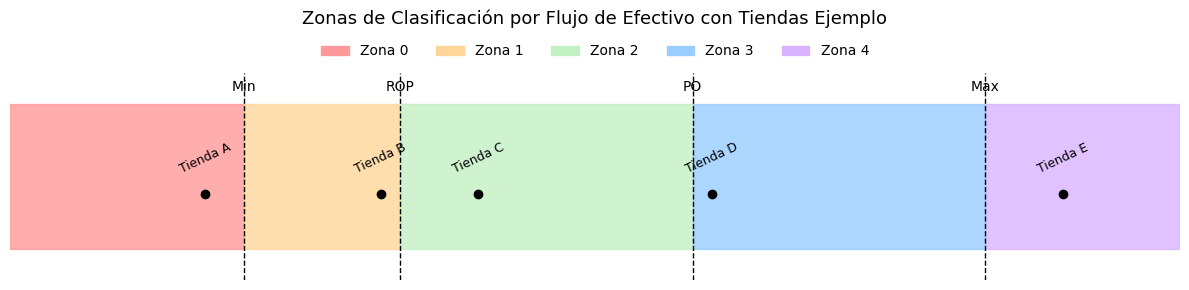

In [12]:

# Parámetros de ejemplo
ROP = 100000
Max = 250000
Min = 0.6 * ROP
PO = (ROP + Max) / 2

# Tiendas ejemplo con flujo_neto
tiendas = {
    "Tienda A": 50000,
    "Tienda B": 95000,
    "Tienda C": 120000,
    "Tienda D": 180000,
    "Tienda E": 270000
}

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 3))

# Zonas visualmente más cortas (altura)
zonas = [
    (0, Min, "Zona 0", "#ff9999"),
    (Min, ROP, "Zona 1", "#ffd699"),
    (ROP, PO, "Zona 2", "#c2f0c2"),
    (PO, Max, "Zona 3", "#99ccff"),
    (Max, Max + 50000, "Zona 4", "#d9b3ff")
]

# Pintar zonas con altura controlada
for start, end, label, color in zonas:
    ax.axvspan(start, end, ymin=0.15, ymax=0.85, color=color, alpha=0.8)

# Líneas y labels de referencia, más altos
for x, name in zip([Min, ROP, PO, Max], ["Min", "ROP", "PO", "Max"]):
    ax.axvline(x, color='black', linestyle='--', linewidth=1)
    ax.text(x, 1.08, name, ha='center', va='bottom', fontsize=10)

# Puntos de tiendas
for nombre, valor in tiendas.items():
    ax.plot(valor, 0.5, 'ko')  # punto negro
    ax.text(valor, 0.62, nombre, ha='center', fontsize=9, rotation=25)

# Ajustes visuales
ax.set_xlim(0, Max + 50000)
ax.set_ylim(0, 1.2)
ax.axis('off')

# Leyenda
handles = [plt.Rectangle((0, 0), 1, 1, color=z[3]) for z in zonas]
labels = [z[2] for z in zonas]
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5, frameon=False)

plt.title("Zonas de Clasificación por Flujo de Efectivo con Tiendas Ejemplo", fontsize=13, pad=35)
plt.tight_layout()
plt.show()

In [13]:
# Exportar a CSV
flujo_efectivo.to_csv("flujo_efectivo_tienda_dia.csv", index=False)

print("✅ Archivo 'flujo_efectivo_tienda_dia.csv' generado correctamente.")

✅ Archivo 'flujo_efectivo_tienda_dia.csv' generado correctamente.
